In [1]:
import pandas as pd
import numpy as np
import statsmodels.graphics.tsaplots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.tools.plotting import autocorrelation_plot
%matplotlib inline

/Users/zoealdington/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


/Users/zoealdington/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


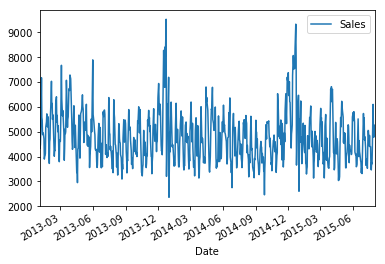

In [2]:
# Load the data and set the DateTime index
data = pd.read_csv('rossmann.csv', skipinitialspace=True)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
# Filter to Store 1
store1_data = data[data.Store == 1]
# Filter to open days
store1_open_data = store1_data[store1_data.Open==1]
# Plot the sales over time
store1_open_data[['Sales']].plot()

In [3]:
print(store1_data.Sales.autocorr(lag=1))
print(store1_data.Sales.autocorr(lag=2))

-0.127325143391
-0.0347871557079


In [7]:
store1_data

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-30,1,4,5020,546,1,1,0,1
2015-07-29,1,3,4782,523,1,1,0,1
2015-07-28,1,2,5011,560,1,1,0,1
2015-07-27,1,1,6102,612,1,1,0,1
2015-07-26,1,7,0,0,0,0,0,0
2015-07-25,1,6,4364,500,1,0,0,0
2015-07-24,1,5,3706,459,1,0,0,0
2015-07-23,1,4,3769,503,1,0,0,0


Here we observe autocorrelation at 40 lag values.  1 and 2 are what we saw before.  
This implies a small but limited impact based on the last few values.  An autoregressive model might be useful.

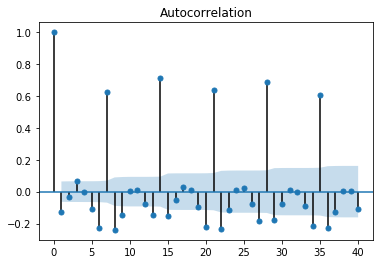

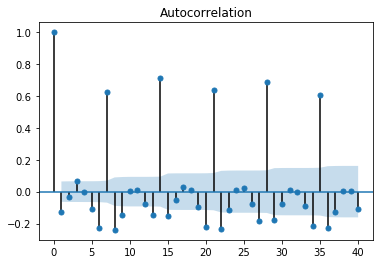

In [4]:
plot_acf(store1_data.Sales, lags=40)

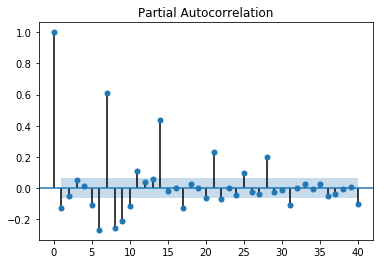

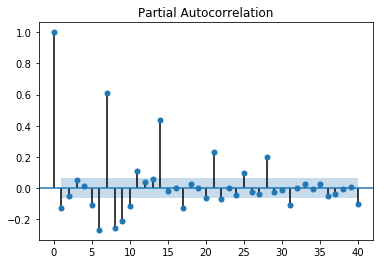

In [5]:
plot_pacf(store1_data.Sales, lags=40)

We also see a larger spike at 7 (the seventh day in the week).  
If we observed a handful of random distributed spikes, a moving average model would be useful.  

In [ ]:
autocorrelation_plot(store1_data.Sales)

To explore AR, MA, and ARMA models, we will use sm.tsa.ARMA.  
Remember, an ARMA model is a combination of autoregressive and moving average models.
We can train an AR model by turning off the MA component (q=0).

By passing (1, 0) in the second argument, we are fitting an ARMA model with p=1, q=0.  This is the same as an AR(1) model.
In this AR(1) model, we learn an intercept (or base sales) value.
Additionally, we learn a coefficient that tells us how to include the latest sales value.
In this case, we add an intercept of ~4700 to 0.68 times the previous month’s sales.  Note that the coefficient is not equal to the lag 1 autocorrelation.  This implies the data is not stationary.

In [ ]:
from statsmodels.tsa.arima_model import ARMA
store1_sales_data = store1_open_data[['Sales']].astype(float)
model = ARMA(store1_sales_data, (1, 0)).fit()
model.summary()

In [ ]:
model.resid.plot()

We can learn an AR(2) model, which regresses each sales value on the last two.
In this case, we learn two coefficients, which tell us the effect of the last two sales values on the current sales.
While this model may perform better, it may be more difficult to interpret.

In [ ]:
model = ARMA(store1_sales_data, (2, 0)).fit()
model.summary()

Residuals are the errors of the model or how off our predictions are.
Ideally, we want randomly distributed errors that are small.
If the errors are large, our model does not perform well.
If the errors have a pattern, particularly over time, we may have overlooked something in the model or have periods of time that are different than the rest of the dataset.

In [ ]:
model.resid.plot()

Here we see large spikes at the end of each year, indicating that our model does not account for the holiday spikes.  
Our model considers a short period of time, so it does not take into account the longer seasonal pattern.

In [ ]:
plot_acf(model.resid, lags=50)

We can also plot the autocorrelations of the residuals.  In an ideal world, these would all be near 0 and appear random.
This plot shows a problem:  the errors are increasing and decreasing every week in a clear pattern.
We may need to expand our model.

To expand this AR model to an ARMA model, we can include the moving average component as well.
Now we learn two coefficients, one for the AR(1) component and one for the MA(1) component.

In [ ]:
model = ARMA(store1_sales_data, (1, 1)).fit()
model.summary()

Remember that this is an AR(1) + MA(1) model.  The AR coefficient represents dependency on the last value and the MA component represents any spikes independent of the last value.
The coefficients here are 0.69 for the AR component and -0.03 for the MA component.  
The AR coefficient is the same as before (decreasing values).
The MA component is fairly small (which we should have expected from the autocorrelation plots).

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(store1_sales_data, (1, 0, 1)).fit()
model.summary()

We can also fit a true ARIMA model to predict the difference of the series.
We can remove the MA component since it does not appear to be useful.
We now have an AR(1) model on the differenced series with a coefficient of -0.18.

In [ ]:
model = ARIMA(store1_sales_data, (1, 1, 1)).fit()
model.summary()

In [ ]:
model = ARIMA(store1_sales_data, (1, 1, 0)).fit()
model.summary()

In [ ]:
 store1_sales_data.Sales.diff(1).autocorr(1)

In [ ]:
 store1_sales_data.Sales.diff(1).plot()

With our models, we can also plot our predictions against the true series using the plot_predict function.
We can compare the last 50 days of true values against our predictions.
The function takes two arguments, the start and end index of the dataframe to plot.  Here, we are plotting the last 50 values.

In [ ]:
model.plot_predict(1, 50)

To plot earlier values with our predictions continuing where the true values stop, we can do the following.
This plots true values in 2014 and our predictions 200 days out from 2014.

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax = store1_sales_data['2014'].plot(ax=ax)
fig = model.plot_predict(1, 200, ax=ax, plot_insample=False)

In [ ]:
fig, ax = plt.subplots()
ax = store1_sales_data['2015'].Sales.plot(ax=ax)
fig = model.plot_predict(1, 190, ax=ax, plot_insample=False)

We can adjust the AR component of the model to adjust for a piece of this.  Let’s increase the lag to 7.
This removes some of the autocorrelation in the residuals but large discrepancies still exist.
However, they exist where we are breaking our model assumptions.

In [ ]:
model = ARIMA(store1_sales_data, (7, 1, 2)).fit()
plot_acf(model.resid, lags=50)
model.summary()

In [ ]:
model.resid.plot()

In [ ]:
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=30)
    rolstd = pd.rolling_std(timeseries, window=30)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [ ]:
test_stationarity(store1_sales_data.Sales)

In [ ]:
import statsmodels.api as sm

#res = sm.tsa.seasonal_decompose(store1_sales_data.Sales.resample('M').mean(),freq =12)
res = sm.tsa.seasonal_decompose(store1_sales_data.Sales,freq =30)

fig = res.plot()
fig.set_size_inches(10, 5)
plt.tight_layout()

### Walmart Sales Data

For the independent practice, we will analyze the weekly sales data from Walmart over a two year period from 2010 to 2012.

The data is again separated by store and by department, but we will focus on analyzing one store for simplicity.

The data includes:

- Store - the store number
- Dept - the department number
- Date - the week
- Weekly_Sales -  sales for the given department in the given store
- IsHoliday - whether the week is a special holiday week


#### Loading the data and setting the DateTimeIndex

In [3]:
data = pd.read_csv('../../assets/dataset/train.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


#### Filter the dataframe to Store 1 sales and aggregate over departments to compute the total sales per store.

In [ ]:
# TODO

#### Plot the rolling_mean for `Weekly_Sales`. What general trends do you observe?

In [ ]:
# TODO

#### Compute the 1, 2, 52 autocorrelations for `Weekly_Sales` and/or create an autocorrelation plot.

In [ ]:
# TODO

In [ ]:
# TODO

In [ ]:
# TODO

#### Split the weekly sales data in a training and test set - using 75% of the data for training

In [ ]:
# TODO

#### Create an AR(1) model on the training data and compute the mean absolute error of the predictions.

In [ ]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

In [ ]:
# TODO

#### Plot the residuals - where are their significant errors.

In [ ]:
# TODO

In [ ]:
# TODO

#### Compute and AR(2) model and an ARMA(2, 2) model - does this improve your mean absolute error on the held out set.

In [ ]:
# TODO

In [ ]:
# TODO

#### Finally, compute an ARIMA model to improve your prediction error - iterate on the p, q, and parameters comparing the model's performance.

In [ ]:
# TODO